In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from plaid.compression.hourglass_vq import HourglassVQLightningModule
from pathlib import Path
import torch

# Setup model, data, and forward pass

In [2]:
#@title Load VQVAE model

dirpath = Path("/homefs/home/lux70/storage/plaid/checkpoints/hourglass_vq/2024-03-05T06-20-52")
ckpt_path = dirpath / "last.ckpt"
vqvae = HourglassVQLightningModule.load_from_checkpoint(ckpt_path)
from plaid.utils import n_params
print(f"{n_params(vqvae):,}")

109,170,688


In [3]:
# load a toy dataloader
from plaid.datasets import CATHShardedDataModule
shard_dir = "/homefs/home/lux70/storage/data/cath/shards"
dm = CATHShardedDataModule(shard_dir=shard_dir)
dm.setup()
train_loader = dm.train_dataloader()

batch = next(iter(train_loader))

In [5]:
# Try forward pass

from plaid.utils import LatentScaler
latent_scaler = LatentScaler()
x, sequences, _ = batch

device = torch.device("cuda")
x_norm = latent_scaler.scale(x)

from plaid.esmfold.misc import batch_encode_sequences
_, mask, _, _, _ = batch_encode_sequences(sequences)

x_norm = x_norm.to(device)
vqvae = vqvae.to(device)
mask = mask.to(device).bool()

# model forward pass!!
recons_norm, loss, log_dict, quant_out = vqvae(x_norm, mask.bool(), log_wandb=False)
print(torch.mean((recons_norm - x_norm) ** 2))


tensor(0.0068, device='cuda:0', grad_fn=<MeanBackward0>)


In [15]:
print(mask.shape)

torch.Size([32, 64])


In [8]:
print(quant_out.keys())
print(quant_out['min_encoding_indices'].shape)
print(quant_out['min_encodings'].shape)

codebook = quant_out['min_encoding_indices']
print(x.shape)
codebook = codebook.reshape(-1, x.shape[1])
print(codebook.shape)
print(codebook)

dict_keys(['loss', 'z_q', 'perplexity', 'min_encodings', 'min_encoding_indices'])
torch.Size([32768, 1])
torch.Size([32768, 128])
torch.Size([32, 64, 1024])
torch.Size([512, 64])
tensor([[111,  43,  11,  ...,  94,  53,  72],
        [  6,  40,  96,  ...,  14, 121, 101],
        [116,  78,  94,  ...,  89,  67,  55],
        ...,
        [ 59, 111,  15,  ...,  91,  48,  98],
        [ 30, 123,  14,  ...,  61,  14,  52],
        [102,   3,  94,  ...,  42,  65,  40]], device='cuda:0')


In [18]:
# B, L, _ = x.shape
reshaped_codebook = codebook.reshape(32, 64, -1)
print(reshaped_codebook.shape)

torch.Size([32, 64, 16])


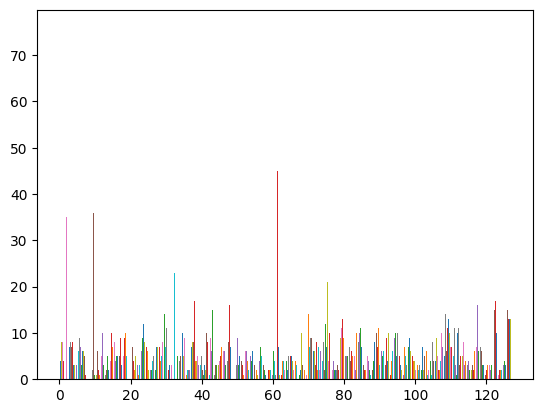

In [25]:
import matplotlib.pyplot as plt
_ = plt.hist(codebook.detach().cpu().numpy(), bins=100)

# Reshape sanity check w/ dummy data

In [23]:
x = torch.tensor(
    [[[1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5],
     [11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,110.5],
     [21.5,22.5,23.5,24.5,25.5,26.5,27.5,28.5,29.5,210.5],
     [31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.5,39.5,310.5],
     [41.5,42.5,43.5,44.5,45.5,46.5,47.5,48.5,49.5,410.5]],
     [[1,2,3,4,5,6,7,8,9,10],
     [11,12,13,14,15,16,17,18,19,110],
     [21,22,23,24,25,26,27,28,29,210],
     [31,32,33,34,35,36,37,38,39,310],
     [41,42,43,44,45,46,47,48,49,410]]]
)
x = x.float()
print(x.shape)  # [2, 5, 10]
y = x.view(-1, 5)
print(y.shape)
print(y)

z = y.reshape(2, 5, -1)
print(z.shape)
print(z)  # should be same order

torch.Size([2, 5, 10])
torch.Size([20, 5])
tensor([[  1.5000,   2.5000,   3.5000,   4.5000,   5.5000],
        [  6.5000,   7.5000,   8.5000,   9.5000,  10.5000],
        [ 11.5000,  12.5000,  13.5000,  14.5000,  15.5000],
        [ 16.5000,  17.5000,  18.5000,  19.5000, 110.5000],
        [ 21.5000,  22.5000,  23.5000,  24.5000,  25.5000],
        [ 26.5000,  27.5000,  28.5000,  29.5000, 210.5000],
        [ 31.5000,  32.5000,  33.5000,  34.5000,  35.5000],
        [ 36.5000,  37.5000,  38.5000,  39.5000, 310.5000],
        [ 41.5000,  42.5000,  43.5000,  44.5000,  45.5000],
        [ 46.5000,  47.5000,  48.5000,  49.5000, 410.5000],
        [  1.0000,   2.0000,   3.0000,   4.0000,   5.0000],
        [  6.0000,   7.0000,   8.0000,   9.0000,  10.0000],
        [ 11.0000,  12.0000,  13.0000,  14.0000,  15.0000],
        [ 16.0000,  17.0000,  18.0000,  19.0000, 110.0000],
        [ 21.0000,  22.0000,  23.0000,  24.0000,  25.0000],
        [ 26.0000,  27.0000,  28.0000,  29.0000, 210.0000